#### Importing Relevant Libraries

In [1]:
import gym
import random
import numpy as np
import tensorflow.compat.v1 as tf
import keras
tf.disable_v2_behavior()
from collections import deque
from matplotlib import pyplot as plt
print("Gym:", gym.__version__)
print("Tensorflow:", tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
Gym: 0.21.0
Tensorflow: 2.7.0


In [2]:
env_name = "CartPole-v0"
env = gym.make(env_name)
print("Observation space:", env.observation_space) # 4 x 1 
print("Action space:", env.action_space)# 2 x 1 

Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)


In [3]:
class QNetwork():
    def __init__(self, state_dim, action_size): # state-dim: input, action_size: ioutput
        # Initializing place holders that will take data input later
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim]) # state vector
        self.action_in = tf.placeholder(tf.int32, shape=[None]) # action taken given the states
        self.q_target_in = tf.placeholder(tf.float32, shape=[None]) # action-value
        action_one_hot = tf.one_hot(self.action_in, depth=action_size) # onehot encoding the final action
        
        # Initializing layers of the Q network
        self.hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu) #Hidden Layer with 100 neurons, activation: relu
        self.q_state = tf.layers.dense(self.hidden1, action_size, activation=None) # Converting inputs in to a q state layer 2 x 1
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state, action_one_hot), axis=1) # converting values to one hot
        
        #Loss function
        self.loss = tf.reduce_mean(tf.square(self.q_state_action - self.q_target_in)) #before

        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
        
    def update_model(self, session, state, action, q_target):
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target}
        session.run(self.optimizer, feed_dict=feed)
        
    def get_q_state(self, session, state):
        q_state = session.run(self.q_state, feed_dict={self.state_in: state})
        return q_state

In [4]:
class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

In [5]:
class DQNAgent():
    def __init__(self, env):
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        self.q_network = QNetwork(self.state_dim, self.action_size)
        self.replay_buffer = ReplayBuffer(maxlen=10000) # Experience Replay: Maximum Batch Length
        self.gamma = 0.97
        self.eps = 1.0
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def get_action(self, state):
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state)
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < self.eps else action_greedy
        return action
    
    def train(self, state, action, next_state, reward, done):
        self.replay_buffer.add((state, action, next_state, reward, done))
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(50)
        q_next_states = self.q_network.get_q_state(self.sess, next_states)
        q_next_states[dones] = np.zeros([self.action_size])
        q_targets = rewards + self.gamma * np.max(q_next_states, axis=1)
        self.q_network.update_model(self.sess, states, actions, q_targets)
        
        if done: self.eps = max(0.1, 0.99*self.eps) # Setting a minimum epsilon 
    
    def __del__(self):
        self.sess.close()
        
 

#### Number of Episodes

In [6]:
num_episodes = 250

#### Training with a Random Agent/ Random Actions 

In [7]:
reward_running_RA = []
mean_reward_RA = []

for episode in range(num_episodes):
    total_reward = 0
    state = env.reset()
    done = False
    
    while not done:
        env.render()
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        reward_running_RA.append(total_reward)
        state = next_state
        
    if episode % 10==0:
        
        mean_reward_RA.append(np.mean(np.array(reward_running_RA)))
        reward_running_RA=[]
        
    print('Episode:', episode, 'Total Reward:', total_reward)
env.close()

Episode: 0 Total Reward: 15.0
Episode: 1 Total Reward: 22.0
Episode: 2 Total Reward: 14.0
Episode: 3 Total Reward: 20.0
Episode: 4 Total Reward: 20.0
Episode: 5 Total Reward: 28.0
Episode: 6 Total Reward: 39.0
Episode: 7 Total Reward: 16.0
Episode: 8 Total Reward: 25.0
Episode: 9 Total Reward: 42.0
Episode: 10 Total Reward: 20.0
Episode: 11 Total Reward: 12.0
Episode: 12 Total Reward: 25.0
Episode: 13 Total Reward: 23.0
Episode: 14 Total Reward: 55.0
Episode: 15 Total Reward: 31.0
Episode: 16 Total Reward: 16.0
Episode: 17 Total Reward: 39.0
Episode: 18 Total Reward: 19.0
Episode: 19 Total Reward: 12.0
Episode: 20 Total Reward: 26.0
Episode: 21 Total Reward: 30.0
Episode: 22 Total Reward: 18.0
Episode: 23 Total Reward: 25.0
Episode: 24 Total Reward: 11.0
Episode: 25 Total Reward: 16.0
Episode: 26 Total Reward: 29.0
Episode: 27 Total Reward: 24.0
Episode: 28 Total Reward: 17.0
Episode: 29 Total Reward: 15.0
Episode: 30 Total Reward: 13.0
Episode: 31 Total Reward: 15.0
Episode: 32 Total 

#### Training with a Model: Deep Q Network

In [8]:
agent = DQNAgent(env)
# num_episodes = 250
reward_running_DQNN=[]; mean_reward_DQNN=[]

for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        agent.train(state, action, next_state, reward, done)
        env.render()
        total_reward += reward
        reward_running_DQNN.append(total_reward)
        state = next_state
    if ep % 10==0:
        
        mean_reward_DQNN.append(np.mean(np.array(reward_running_DQNN)))
        reward_running_DQNN=[]
        
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
    
    

<ipython-input-3-d28197f4c364>:10: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu) #Hidden Layer with 100 neurons, activation: relu
C:\Users\shekh\anaconda3\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
<ipython-input-3-d28197f4c364>:11: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.q_state = tf.layers.dense(self.hidden1, action_size, activation=None) # Converting inputs in to a q state layer 2 x 1


Episode: 0, total_reward: 13.00
Episode: 1, total_reward: 11.00
Episode: 2, total_reward: 22.00
Episode: 3, total_reward: 38.00
Episode: 4, total_reward: 18.00
Episode: 5, total_reward: 16.00
Episode: 6, total_reward: 30.00
Episode: 7, total_reward: 12.00
Episode: 8, total_reward: 46.00
Episode: 9, total_reward: 17.00
Episode: 10, total_reward: 15.00
Episode: 11, total_reward: 19.00
Episode: 12, total_reward: 14.00
Episode: 13, total_reward: 13.00
Episode: 14, total_reward: 37.00
Episode: 15, total_reward: 24.00
Episode: 16, total_reward: 15.00
Episode: 17, total_reward: 18.00
Episode: 18, total_reward: 14.00
Episode: 19, total_reward: 12.00
Episode: 20, total_reward: 15.00
Episode: 21, total_reward: 9.00
Episode: 22, total_reward: 12.00
Episode: 23, total_reward: 36.00
Episode: 24, total_reward: 12.00
Episode: 25, total_reward: 15.00
Episode: 26, total_reward: 27.00
Episode: 27, total_reward: 14.00
Episode: 28, total_reward: 24.00
Episode: 29, total_reward: 11.00
Episode: 30, total_re

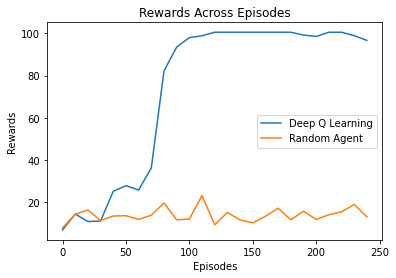

In [9]:
plt.plot(mean_reward_DQNN,label='Deep Q Learning')
plt.plot(mean_reward_RA, label='Random Agent')
plt.xticks([0, 5, 10, 15, 20, 25],[0, 50, 100, 150, 200, 250])
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Rewards Across Episodes')
plt.legend()
plt.show()